# Simulating the effects of missing data in *SVDquartets*
To explore the effects of missing data on the accuracy of *SVDquartets*, ddrad datasets will be simulated, varying levels of data will be convereted to `N`'s, *SVDquartets* will be run, and accuracy will be assessed with the Robinson-Foulds distance. Here's a brief outline:

1. Load modules, make a few useful definitions
2. Simulate datasets
  
 2.1 Define simulation parameters
    * Data type
    * Locus size
    * Number of loci per library
    * Effective population size
    * True tree simulated under
    
 2.2 Run *simRRLs* and *pyRAD*
3. Create missing data replicates
4. Run *SVDquartets*
5. Calculate RF distance
6. Parallelize

**I highly recommend reading the docs for [*simRRLS*](http://dereneaton.com/radseq/simulating_raw_radseq_data/), [*(i)pyRAD*](http://dereneaton.com/software/pyrad/), and [*ASTRAL-II*](https://github.com/smirarab/ASTRAL/blob/master/astral-tutorial.md). SVDquartets does not have a devoted docs/tutorials page but [Dr. Laura Kubatko's molevol page is very helpful](https://molevol.mbl.edu/index.php/Laura_Kubatko)** 
    

### 1. Load modules, make a few useful definitions

In [53]:
# Handle IO, sysargs, subprocesses
import sys
import os
import shutil
import subprocess
from subprocess import Popen, PIPE
import glob
# Data parsing
import numpy as np
import pandas as pd
import numpy.random as rand
import re
# Bioinformatics
from Bio import AlignIO, Alphabet
import dendropy
from ete3 import Tree, TreeStyle
# Parallelization
from multiprocessing import Pool, Process, current_process, cpu_count
from multiprocessing.managers import SyncManager
import signal
# Loading bars and miscellaneous
from tqdm import tqdm, tnrange, tqdm_notebook

The next few definitions make our work a little easier and more readable.

In [54]:
def listabs(directory):
    '''Returns the absolute path of all items in a directory
    
    Parameters
    ----------
    directory : path to directory'''
    return [os.path.join(directory, filename) for filename in os.listdir(directory)]

In [55]:
class Vividict(dict):
    '''An infinitely nestable dictionary
    
    Parameters
    -----------
    dict : a dictionary
     '''
    def __missing__(self, key):
        value = self[key] = type(self)() # retain local pointer to value
        return value                     # faster to return than dict lookup

In [56]:
def remove_all(directory):
    '''Recursively removes everything in a directory
    
    Parameters
    ----------
    directory : path to directory'''
    files = glob.glob(directory+'*')
    for f in files:
        if os.path.isdir(f): shutil.rmtree(f)
        else: os.remove(f)

In [57]:
def multiply_strints(mystring, by):
    '''Multiplies all integers in a string by a value.
    
    Parameters
    ----------
    mystring : a string
    by : factor to multiply by '''
    return re.sub(
        re.compile("\d+"), 
        lambda matchobj: str(int(matchobj.group(0))*by), mystring)

In [58]:
flatten = lambda l: [item for sublist in l for item in sublist]

## 2. Simulate datasets

First, let's create (if we haven't already) and move into a new directory where our simulations will live

In [59]:
print('Current working directory: %s\n') % (os.getcwd())
sim_dir = '/Users/IanGilman/pythonscripts/SimMissingData/'
try: 
    os.mkdir(sim_dir)
    print('Created new simulation directory: %s\n') % (sim_dir)
except OSError: 
    print('Directory %s already exists\n') % (sim_dir)
os.chdir(sim_dir)
print('Current working directory: %s\n') % (os.getcwd())

Current working directory: /Users/IanGilman/pythonscripts/SimMissingData/l100L200SmbNl

Directory /Users/IanGilman/pythonscripts/SimMissingData/ already exists

Current working directory: /Users/IanGilman/pythonscripts/SimMissingData



### 2.1 Define simulation parameters
Next, we'll define the tree to simulate under. We'll stick with a balanced tree with internal branch lengths of 1.0 coalescent units for now. At the end we'll put everything together to run any number of different topologies/parameters in a parallelized way.

In [60]:
MedBalTree = '(((((A:1,B:1):1,C:2):1,D:3):1,(((E:1,F:1):1,G:2):1,H:3):1):1,(((I:1,J:1):1,K:2):1,L:3):2);'
path = os.path.join(sim_dir, 'MedBalTree')
if not os.path.exists(path):
    with open(path, 'w+') as f:
        f.write(MedBalTree)

We can view the topology we're simulating under using the ete3 module. We'll add the branch length (in coalescent units) along the tops of the branches.

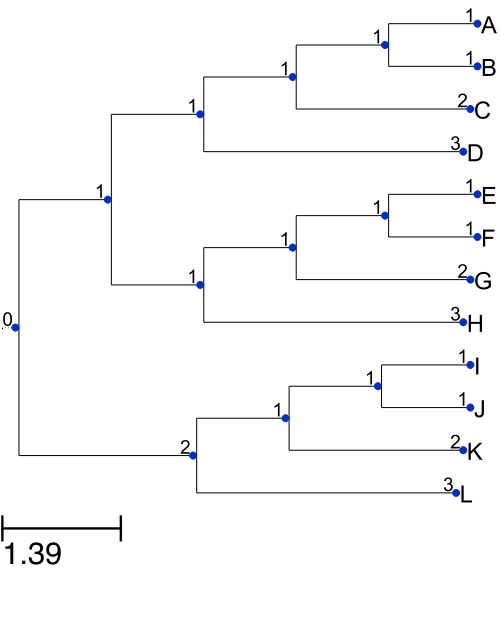

In [61]:
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = True
tree = Tree(MedBalTree)
tree.render("%%inline", w =500, tree_style=ts)

For speed, we'll work with a small data set of 200 loci, all of length 100bp, and all taxa will have an effective population size ($N_e$) of $1e5$, which is constant in size along all branches.

In [62]:
sim_params = {'n_loci':200, 'locus_size':100, 'Ne':1e5, 'treeshape':'mb', 'treepath':path, 'Ne_cat': 'l'}

Finally, we need a simulation name for output files that's informative about the simulation parameters (for when we have many simulations). I'll stick with a format indicative of the parameters passed to *simRRLs*: `l<locus_size>L<n_loci>S<treeshape>N<Ne>`. I'll refer to $N_e$ as 'l' (low, $1e4$), 'm' (medium, $1e5$), and 'h' (high, $1e6$). Note that 'mb' refers to medium, balanced.

In [63]:
simname = 'l%dL%dS%sN%s' % (sim_params['locus_size'], sim_params['n_loci'], sim_params['treeshape'], 
                            sim_params['Ne_cat'])
print simname

l100L200SmbNl


### 2.2 Run *simRRLs* and *pyRAD*

We'll want to have a separate directory for each simulation.

In [64]:
print('Current working directory: %s\n') % (os.getcwd())
current_simdir = os.path.join('/Users/IanGilman/pythonscripts/SimMissingData/', simname)
try: 
    os.mkdir(current_simdir)
    print('Created new simulation directory: %s\n') % (current_simdir)
except OSError: 
    print('Directory %s already exists\n') % (current_simdir)
os.chdir(current_simdir)
print('Current working directory: %s\n') % (os.getcwd())

Current working directory: /Users/IanGilman/pythonscripts/SimMissingData

Directory /Users/IanGilman/pythonscripts/SimMissingData/l100L200SmbNl already exists

Current working directory: /Users/IanGilman/pythonscripts/SimMissingData/l100L200SmbNl



**Run *simRRLs***

I'm interested in ddRAD because of my empirical work in *Chloropyron* (Orobanchaceae), but RAD, GBS, paired-end ddRAD, and paired-end GBS can also be simulated. Here's what our command would look like entered into the command line:

In [65]:
simrrlls_call = '-o %s -f ddrad -l %d -L %d -N %s -t %s' % (simname, 
                                                            sim_params['locus_size'], 
                                                            sim_params['n_loci'],
                                                            sim_params['Ne'],
                                                            sim_params['treepath'])
print("bash\n>> %s") % (simrrlls_call)

bash
>> -o l100L200SmbNl -f ddrad -l 100 -L 200 -N 100000.0 -t /Users/IanGilman/pythonscripts/SimMissingData/MedBalTree


Note that the final command in the chunk below, `<function>.wait()`, waits for the `<function>` subprocess to finish before continuing. It will return '0' be default.

In [66]:
run_simrrls = Popen(['simrrls', '-o', simname, 
                      '-f', 'ddrad', 
                      '-l', str(sim_params['locus_size']), 
                      '-L', str(sim_params['n_loci']), 
                      '-N', str(sim_params['Ne']),
                      '-t', sim_params['treepath']])
run_simrrls.wait()

0

**Run *pyRAD***

To run *pyRAD* we'll first need to create a params file. We'll create one, slightly change the barcode file path name from *simRRLs* so it's recognized by default by *pyRAD*, and change a few settings. For the purpose of our study, we'll change the restriction overhang, number of processors, datatype, output prefix, and output formats.

In [67]:
new_params_call = 'pyrad -n' 
print("bash\n>> %s") % (new_params_call)
create_new_params = Popen(['/Users/IanGilman/pyrad/pyrad/pyRAD.py', '-n'])
create_new_params.wait()

bash
>> pyrad -n


0

In [68]:
old_bc_file = simname+'_barcodes.txt'
new_bc_file = simname+'.barcodes'
if not os.path.exists(new_bc_file):
    shutil.move(old_bc_file, new_bc_file)

In [69]:
# Read old lines
with open('params.txt', 'r') as p:
    paramsdata =  p.readlines()

# Edit lines
newlines = []
for line in paramsdata:
    if 'Restriction overhang' in line:
        line = 'CTGCAG, CCGG                     ## 6. Restriction overhang (e.g., C|TGCAG -> TGCAG)     (s1,s2)\n'
    if 'N processors' in line:
        line = '%d                         ## 7. N processors (parallel)                           (all)\n' % (cpu_count())
    if 'Datatype' in line:
        line = 'ddrad                       ## 11. Datatype: rad,gbs,pairgbs,pairddrad,(others:see docs)(all)\n'
    if 'Prefix name' in line:
        line = '%s.c88d6m4p3                 ## 14. Prefix name for final output (no spaces)         (s7)\n' % (simname)
    if 'output formats' in line:
        line = '*                       ## 30.opt.: output formats: p,n,a,s,v,u,t,m,k,g,* (see docs) (s7)\n'
    newlines.append(line)

# Write new lines
with open('params.txt', 'w') as p:
    p.writelines(newlines)

Now we're ready to run *pyRAD*

In [70]:
pyrad_call = 'pyrad -p params.txt -s 1234567' 
print("bash\n>> %s") % (pyrad_call)
run_pyrad = Popen(['/Users/IanGilman/pyrad/pyrad/pyRAD.py', '-p', 'params.txt', '-s', '1234567'])
run_pyrad.wait()

bash
>> pyrad -p params.txt -s 1234567


0

### 3. Create missing data replicates

With our output files in hand, we can now randomly remove data. We'll work with phylip files for simplicity, but have to convert back to nexus for input into PAUP*. We'll begin by reading a phylip file into a DataFrame.

In [71]:
# Read phylip data
phylip = './outfiles/%s.c88d6m4p3.phy' % (simname)
with open(phylip, 'r') as p:
    phylipdata = p.readlines()

# Split all sites 
splitdata = []
for line in phylipdata[1:]:
    splitdata.append(line.split())
for i, line in enumerate(splitdata):
    splitdata[i][1] = list(splitdata[i][1])    
flatdata = []
for line in splitdata:
    flatdata.append([line[0]]+line[1])

# Write to dataframe
datadf = pd.DataFrame(flatdata)
datadf.set_index(keys=[0], inplace=True)

datadf

,1,2,3,4,5,6,7,8,9,10,...,16991,16992,16993,16994,16995,16996,16997,16998,16999,17000
0,,,,,,,,,,,,,,,,,,,,,
A_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
B_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
C_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
D_0,T,G,A,T,T,T,C,S,C,G,...,A,G,T,G,C,G,G,A,C,T
E_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
F_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
G_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
H_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T
I_0,T,G,A,T,T,T,C,C,C,G,...,A,G,T,G,C,G,G,A,C,T


For now, we'll remove 50% of the data, but in the full program we'd loop over many rates of missing data. To keep track of these unique datasets we'll add a prefix to our filenames.

In [72]:
percent = 30
# Create string for naming files
p = '.p'+str(percent).zfill(2)

# Get number of entries
entries = datadf.shape[0]*datadf.shape[1]

# Substitute rand percent with 'N'
if percent==0: missingdf=datadf
else: missingdf = datadf.where(np.random.uniform(size=datadf.shape) > float(percent/100.), 'N')

missingdf

,1,2,3,4,5,6,7,8,9,10,...,16991,16992,16993,16994,16995,16996,16997,16998,16999,17000
0,,,,,,,,,,,,,,,,,,,,,
A_0,T,G,A,N,N,T,C,N,N,G,...,A,N,N,N,C,G,G,A,C,T
B_0,T,G,A,N,T,N,N,C,C,G,...,N,G,T,N,C,G,G,N,C,T
C_0,T,N,A,T,T,N,C,C,C,N,...,A,N,T,N,N,G,G,A,N,T
D_0,T,G,A,N,T,T,N,S,N,N,...,A,G,T,G,N,G,N,N,C,N
E_0,T,G,A,T,T,T,N,N,C,N,...,N,N,T,G,C,G,N,A,C,T
F_0,T,N,N,T,T,T,N,C,C,G,...,N,G,T,G,N,G,G,A,C,T
G_0,T,N,A,N,N,N,C,C,C,G,...,A,G,N,N,C,G,N,A,C,N
H_0,T,G,A,T,T,T,C,N,C,N,...,A,G,T,G,N,G,G,A,N,T
I_0,T,N,N,T,N,N,C,C,N,G,...,N,N,T,G,C,G,G,A,N,T


In [73]:
# Convert dataframe to sequence strings
missinglines =[]
meta = ('%d %d\n') % (datadf.shape[0], datadf.shape[1])
missinglines.append(meta)
for i in xrange(len(missingdf)):
    missinglines.append('       '.join([missingdf.index[i],''.join(missingdf.ix[i])])+'\n')
    
# Write strings to phylip file
with open(simname+p+'.phy', 'w+') as m:
    m.writelines(missinglines)
    missing_phy = simname+p+'.phy'
    print('Wrote %d percent missing data phylip file to %s') % (percent, missing_phy)

# Convert phlyip to nexus for PAUP
alignment = AlignIO.read(open(simname+p+'.phy'), "phylip", alphabet=Alphabet.generic_dna)
with open(simname+p+'.nex', "w+") as n:
    n.write(alignment.format("nexus"))
    missing_nex = simname+p+'.nex'
    print('Wrote %d missing data nexus file to %s') % (percent, missing_nex)

Wrote 30 percent missing data phylip file to l100L200SmbNl.p30.phy
Wrote 30 missing data nexus file to l100L200SmbNl.p30.nex


### 4. Run *SVDquartets*

To run *SVDquartets* we'll have to add a PAUP block to our nexus file. This will specify that we want to PAUP to 

1. autoclose after finishing
2. run SVDquartets
    * all quartets analyzed
    * missing data set to 'Missing'
3. save the output as newick trees

Here's an example:

    BEGIN PAUP;
        set autoclose=yes;
        SVDquartets evalQuartets=all ambigs=missing;
        SaveTrees file=FILENAME format=Newick;
        quit;
    End;

In [74]:
saveline = '\tSaveTrees file=%s.p%s.tre format=Newick brLens=no;\n' % (simname, str(percent).zfill(2))
paup_lines = ['\nBEGIN PAUP;\n', '\tset autoclose=yes;\n', 
              '\tSVDquartets evalQuartets=all ambigs=missing;\n',
              saveline, '\tquit;\n', 'End;\n']

with open(missing_nex, 'a') as n:
        n.writelines(paup_lines)

Finally, let's run *SVDquartets*. We'll set PAUP* to 'non-interactive' mode.

In [92]:
svdquartets_call = 'paup4 -n %s' % (missing_nex)
print("bash\n>> %s") % (svdquartets_call)

run_svdquartets = Popen(['paup4', '-n', missing_nex], stdin=PIPE, stdout=PIPE, stderr=PIPE)
run_svdquartets.wait()

bash
>> paup4 -n l100L200SmbNl.p30.nex


0

Now we can view our species tree estimate

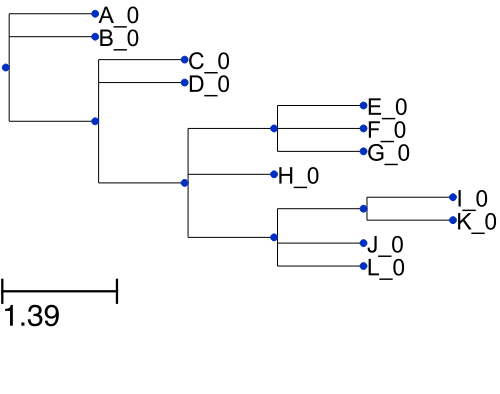

In [86]:
ts = TreeStyle()
ts.show_leaf_name = True
p30_tree = Tree('./l100L200SmbNl.p30.tre')
p30_tree.render("%%inline", w =500, tree_style=ts)

Notice that *simRRLs* added '_0' to each taxon denoting that they are the only sample of that taxon. We'll need to trim those before comparing trees.

In [99]:
def rename_taxa(treefile):
    '''Replaces '_0' in taxa
    
    Parameters
    ----------
    treefile : path to a newick tree file'''
    
    with open(treefile, 'r') as tin:
        newick = tin.readlines()[0]
    with open(treefile, 'w') as tout:
        tout.writelines(newick.replace('_0', ''))

In [98]:
rename_taxa(treefile=missing_nex.replace('nex', 'tre'))

### 5. Calculate Robinson-Foulds distance

To assess the accuracy of our estimated species tree we'll use the normalized Robinson-Foulds (RF) distance (Robinson and Foulds 1981). This measures the number of bipartitions in our true tree that are not present in our estimated tree, and vice versa. It has a maximum value of $2(n-3)=18$ for our 12-taxon tree. For generality, we will normalize our RF distances by this value.

For various reasons, I'm using DendroPy 3.12, and we *actually* want to use the `symmetric_difference`, *not* `robinson_foulds_distance` function because we do not have branch lengths. In addition, there is a [known error](https://github.com/jeetsukumaran/DendroPy/issues/14) in behavior of this function. I wrote the work around suggested by Jeet Sukumaran below as a function.

In [95]:
def sym_diff(t1, t2):
    '''This is a fix version of the symmetric difference function in Dendropy written by Jeet Sukumaran
    (see his GitHub)
    
    Parameters
    ----------
    t1 : first tree path
    t2 : second tree path'''
    
    taxon_namespace = dendropy.TaxonSet()
    
    t1 = dendropy.Tree.get_from_path(t1, "newick", taxon_set=taxon_namespace)
    t2 = dendropy.Tree.get_from_path(t2, "newick", taxon_set=taxon_namespace)
    t1.is_rooted
    t2.is_rooted
    t1.symmetric_difference(t2)
    t1.symmetric_difference(t2)

    return t2.symmetric_difference(t1)

In [96]:
RF = sym_diff(t1='./l100L200SmbNl.p30.tre', t2 = '../MedBalTree')
norm_RF = RF/18.
print(RF, norm_RF)

(6, 0.3333333333333333)


Notice that our RF distance is 6, despite the fact that our estimated and true trees are not *incongruent*. There are multiple polytomies in our estimated topology, so there are bipartitions in our true tree that are not present in the estimate, but no bipartition in our estimate is not present in our true tree.

### 6. Parallelize
Now that we've been through one iteration using one set of parameters, we'd like to efficiently loop through all of the parameter values and simulation replicates. This involves pushing a lot of the above work to a series of functions and then dividing up work using the `multiprocessing` module. We'll also add a few safeguards to make sure everything has run okay and speed things up by skipping sections if they've already been completed.

In [100]:
os.chdir(sim_dir)
print os.getcwd()

/Users/IanGilman/pythonscripts/SimMissingData


In [101]:
def run_simrrls(simname, method, size, n_loci, Ne, tree_path):
    '''Simulated RADseq loci.
    
    Parameters
    ----------
    simname : simulation name
    method : method of library simulation (ddrad, rad, gbs, pairddrad, pairgbs)
    size : size in basepairs of loci to simulate
    nloci : number of loci to simulate
    shape : shape of tree
    ne : effective population size
    treeshapes : dictionary where keys are tree shapes (in shape) and values are paths to specific tree'''
    
    run_simrrls = Popen(['simrrls', '-o', simname, 
                      '-f', 'ddrad', 
                      '-l', str(size), 
                      '-L', str(n_loci), 
                      '-N', str(Ne),
                      '-t', tree_path])
    run_simrrls = Popen(['/Users/IanGilman/pyrad/pyrad/pyRAD.py', '-p', 'params.txt', '-s', '1234567'])
    run_simrrls.wait()

In [102]:
def run_pyrad(simname, pyrad = '/Users/IanGilman/pyrad/pyrad/pyRAD.py'):
    '''Creates and renames the params file created by pyrad so it is detected by default
    and then runs pyrad with a few parameters altered.
    Parameters
    ----------
    simname : simulation name
    pyrad : path to pyRAD '''
    
    # Create new params file
    create_new_params = Popen(['/Users/IanGilman/pyrad/pyrad/pyRAD.py', '-n'])
    create_new_params.wait()
    
    # Rename barcodes file so it's recognized by default by pyRAD
    old_bc_file = simname+'_barcodes.txt'
    new_bc_file = simname+'.barcodes'
    if os.path.exists(old_bc_file):
        shutil.move(old_bc_file, new_bc_file)
    
    # Read old lines
    with open('params.txt', 'r') as p:
        paramsdata =  p.readlines()

    # Edit lines
    newlines = []
    for line in paramsdata:
        if 'Restriction overhang' in line:
            line = 'CTGCAG, CCGG                     ## 6. Restriction overhang (e.g., C|TGCAG -> TGCAG)     (s1,s2)\n'
        if 'N processors' in line:
            line = '%d                         ## 7. N processors (parallel)                           (all)\n' % (cpu_count())
        if 'Datatype' in line:
            line = 'ddrad                       ## 11. Datatype: rad,gbs,pairgbs,pairddrad,(others:see docs)(all)\n'
        if 'Prefix name' in line:
            line = '%s.c88d6m4p3                 ## 14. Prefix name for final output (no spaces)         (s7)\n' % (simname)
        if 'output formats' in line:
            line = '*                       ## 30.opt.: output formats: p,n,a,s,v,u,t,m,k,g,* (see docs) (s7)\n'
        newlines.append(line)

    # Write new lines
    with open('params.txt', 'w') as p:
        p.writelines(newlines)
    
    run_pyrad = Popen([pyrad, '-p', 'params.txt', '-s', '1234567'])
    run_pyrad.wait()

In [103]:
def phylip_to_df(simname):
    '''Converts a phylip file to a pandas DataFrame
    
    Parameters
    ----------
    simname : simulation name'''
    
    # Read phylip data
    phylip = './outfiles/%s.c88d6m4p3.phy' % (simname)
    with open(phylip, 'r') as p:
        phylipdata = p.readlines()

    # Split all sites 
    splitdata = []
    for line in phylipdata[1:]:
        splitdata.append(line.split())
    for i, line in enumerate(splitdata):
        splitdata[i][1] = list(splitdata[i][1])    
    flatdata = []
    for line in splitdata:
        flatdata.append([line[0]]+line[1])

    # Write to dataframe
    datadf = pd.DataFrame(flatdata)
    datadf.set_index(keys=[0], inplace=True)

    return datadf

In [104]:
def write_missing_data(fulldf, percent, simname):
    '''Simulates missing data given a DataFrame of sequence data and writes it to file.
    
    Parameters
    ----------
    fulldf : pandas DataFrame containing the full data
    percent : percent missing data to simulate
    simname : simulation name'''
    
    # Create string for naming files
    p = '.p'+str(percent).zfill(2)

    # Get number of entries
    entries = datadf.shape[0]*datadf.shape[1]

    # Substitute rand percent with 'N'
    if percent==0: missingdf=datadf
    else: missingdf = datadf.where(np.random.uniform(size=datadf.shape) > float(percent/100.), 'N')

    # Convert dataframe to sequence strings
    missinglines =[]
    meta = ('%d %d\n') % (datadf.shape[0], datadf.shape[1])
    missinglines.append(meta)
    for i in xrange(len(missingdf)):
        missinglines.append('       '.join([missingdf.index[i],''.join(missingdf.ix[i])])+'\n')

    # Write strings to phylip file
    with open(simname+p+'.phy', 'w+') as m:
        m.writelines(missinglines)
        missing_phy = simname+p+'.phy'

    # Convert phlyip to nexus for PAUP
    alignment = AlignIO.read(open(simname+p+'.phy'), "phylip", alphabet=Alphabet.generic_dna)
    with open(simname+p+'.nex', "w+") as n:
        n.write(alignment.format("nexus"))
        missing_nex = simname+p+'.nex'
        
    saveline = '\tSaveTrees file=%s.p%s.tre format=Newick brLens=no;\n' % (simname, str(percent).zfill(2))
    paup_lines = ['\nBEGIN PAUP;\n', '\tset autoclose=yes;\n', 
                  '\tSVDquartets evalQuartets=all ambigs=missing;\n',
                  saveline, '\tquit;\n', 'End;\n']

    with open(missing_nex, 'a') as n:
            n.writelines(paup_lines)
        
    return missing_nex

The following function will run through an entire simulation and follows the basic outline for a single set of parameters above, but it has some wrappers that allow it to run in a parallel on our Linux stand-alone servers. The use of the `shared_array` in conjunction with `SyncManager` and `mgr_init` allows us to stop running with a `KeyboardInterrupt` (or kernel interrupt in Jupyter). See [Johnathon Tushman's GitHub](http://jtushman.github.io/blog/2014/01/14/python-%7C-multiprocessing-and-interrupts/) for more detailed infomation. Another issue in which threads were not properly communicating is circumvented in the `try`/`except` block containing `BaseProxy._address_to_local`, see [StackOverflow](https://stackoverflow.com/questions/3649458/broken-pipe-when-using-python-multiprocessing-managers-basemanager-syncmanager). 

In [109]:
def SVD_simulation(size, n_loci, shape, Ne, treeshapes, Nes, process_number, shared_array, svd_limit = 100):
    '''
    Runs a complete simulation from creation of a new simulation directory through calculation of normalized
    RF distance between estimated and true tree in SVDquartets.
    
    Parameters
    ----------
    size : locus size in basepairs
    n_loci : number of loci in library
    shape : key to dictionary of treeshapes
    Ne : key to dictionary of effective population sizes
    treeshapes : dictionary of tree shapes and paths to tree files
    Nes : dictionary of effective population sizes
    process_number : process number in the shared array of concurrent processes
    shared_array : array of concurrent processes initiated
    svd_limit = number of tries of SVDquartets to find informative quartets (default 100)'''
    
    try:
        while True:
            
            try: 
                if address in BaseProxy._address_to_local:
                    del BaseProxy._address_to_local[address][0].connection
            except NameError: None

            shared_array.append(process_number)
            print('Started thread: %d') % (process_number)

            # Get values from simulation name
            proc = os.getpid()

            # Get simulation name
            simname = 'l%dL%dS%sN%s' % (size, n_loci, shape, Ne)

            # Make/switch directories
            print('Simulation: %s\n\tLocus size: %dbp\n\tLibrary size: %d loci\n\tTree shape: %s\n\tNe: %d\n\tProcess ID: %d\n') % (simname, size, n_loci, shape, Nes[Ne], proc)
            print('Current working directory: %s\n') % (os.getcwd())
            current_simdir = os.path.join('/Users/IanGilman/pythonscripts/SimMissingData/', simname)
            try: 
                os.mkdir(current_simdir)
                print('Created new simulation directory: %s\n') % (current_simdir)
            except OSError: 
                print('Directory %s already exists\n') % (current_simdir)
            os.chdir(current_simdir)
            print('Current working directory: %s\n') % (os.getcwd())

            # Initialize final output
            reps = 10 
            finaloutput = os.path.join(os.getcwd(), simname+'.SVD.RF.csv')
            # Check to see if simulation has already been completed
            if os.path.exists(finaloutput):
                print('\tFound SVD RF file for %s. Checking for completion...\n') % (simname)
                with open(finaloutput, 'r') as f:
                    if not len(f.readlines())==reps+1:
                        print('\t%s SVD RF file not complete. Rerunning...\n') % (simname)
                    else:
                        print('\t%s SVD RF file complete. Move/remove it to recalcualte. Exitting...\n') % (simname)
                        sys.exit() 
            # Initialize dict for RF distances
            treedist = {}
            
            ## Simulate library if it has not already been done.
            if not os.path.exists(simname+'_R1_.fastq.gz'):
                print('Running simRRLs for %s\n') % (simname)
                run_simrrls(simname=simname, method='ddrad', size=size, n_loci=n_loci, Ne=Nes[Ne], tree_path=treeshapes[shape]['path'])

                print('simRRLs finished for %s\n') % (simname)
            else: 
                print('Dataset %s already simulated. Move/remove it to rerun. Continuing to pyRAD...\n') % (simname)

            ## Run pyRAD
            phy_file = os.path.join(os.getcwd(), 'outfiles/'+simname+'.c88d6m4p3.phy')
            print('Looking for %s...\n') % (phy_file)
            if os.path.exists(phy_file):
                print('pyRAD complete for %s. Move/remove results to rerun. \n') % (simname)
            else: 
                print('Running pyRAD for %s...\n') % (simname)
                run_pyrad(simname=simname)
                print('pyRAD finished for %s\n') % (simname)

            ##  Read phylip file to datframe 
            fulldata = phylip_to_df(simname=simname)

            ## Loop over percents
            for percent in tqdm_notebook(range(0,85,10), desc=simname+' percent missing data: ', leave=False):

                # Initialize dict key and list
                pkey = 'p'+str(percent).zfill(2)
                treedist[pkey] = []

                # Loop over replicates
                for i, rep in tqdm_notebook(enumerate(range(reps)), desc=simname+' replicates: ', leave=False):
                    missing_percent_nex = simname+'.p'+str(percent).zfill(2)+'.nex'            

                    # Delete old missing data file if present
                    if os.path.exists(missing_percent_nex):
                        os.remove(missing_percent_nex)

                    # When missing data is high, there are not informative quartets found in SVDquartets.
                    # When this happens we will resample missing data and try again if/until a limit, 'svd_limit'
                    # is reached. Then a complete polytomy will be returned.
                    SVDoutput = 'No informative quartets were found'
                    counts = 0
                    while ('No informative quartets were found' in SVDoutput) and (counts<svd_limit):
                        # Write missing data and run SVDquartets
                        missing_percent_nex = write_missing_data(fulldf=fulldata, percent=percent, simname=simname)
                        run_svdquartets = Popen(['paup4', '-n', missing_percent_nex], stderr=PIPE, stdin=PIPE, stdout=PIPE)
                        run_svdquartets.wait()
                        SVDoutput, b = run_svdquartets.communicate(b"input data that is passed to subprocess' stdin")
                        counts+=1

                        # If we've hit the limit, write polytomy
                        if counts==svd_limit:
                            species_tree_path = '%s.p%s.tre' % (simname, str(percent).zfill(2))
                            with open(species_tree_path, 'w+') as s:
                                s.write('(A,B,C,D,E,F,G,H,I,J,K,L);')

                    species_tree_estimate = re.sub('nex', 'tre', missing_percent_nex)
                    rename_taxa(species_tree_estimate)
                    # Calculate RF distance
                    RF = sym_diff(t1=species_tree_estimate, t2 = treeshapes[shape]['path'])
                    norm_RF = RF/18.
                    treedist[pkey].append(norm_RF)

            pd.DataFrame.from_dict(treedist).to_csv(path_or_buf=finaloutput)
            print('Final RF distance matrix written to %s\n') % (finaloutput)
            return treedist

    except KeyboardInterrupt:
        print "Keyboard interrupt in process: ", process_number
    finally:
        print "cleaning up thread", process_number

In [110]:
def mgr_init():
    '''Explicit initialization of sync manager'''
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    print 'Initialized manager'

In [111]:
# Initiate dict for trees and filepaths 
treeshapes = Vividict()

MedBalTree = '(((((A:1,B:1):1,C:2):1,D:3):1,(((E:1,F:1):1,G:2):1,H:3):1):1,(((I:1,J:1):1,K:2):1,L:3):2);'
ShortBalTree = multiply_strints(MedBalTree, 0.5).replace('.0', '') # halve branch lengths
LongBalTree = multiply_strints(MedBalTree, 2.0).replace('.0', '') # double branch lengths

treeshapes['sb']['tree'] = ShortBalTree
treeshapes['mb']['tree'] = MedBalTree
treeshapes['lb']['tree'] = LongBalTree

# Write trees to files
for key in treeshapes.iterkeys():
    path = os.path.join(sim_dir, key)
    treeshapes[key]['path'] = str(path)
    with open(path, 'w+') as f:
        f.write(treeshapes[key]['tree'])

#----- SIMULATION PARAMETERS -----#
library_sizes = [500, 1000]
locus_sizes = [400, 500, 600]
Nes = {'l':1e4, 'm': 1e5, 'h':1e6}
SVD_limit = 10

# Create list of parameter settings for input into SVD_simulation
params = []
for number in library_sizes:
    for size in locus_sizes:
        for shape in treeshapes.keys():
            for Ne in Nes.keys():
                params.append([size, number, shape, Ne])

We'll only run through the first 5 simulations below

In [115]:
if __name__ == '__main__':

    processes = []

    # now using SyncManager vs a Manager
    manager = SyncManager()
    # explicitly starting the manager, and telling it to ignore the interrupt signal
    manager.start(mgr_init)
    try:
        shared_array = manager.list()

        for PID, param in tqdm_notebook(enumerate(params[:2]), desc='Simulations '):
            p = Process(target=SVD_simulation, 
                        args=(param[0], param[1], param[2], param[3], treeshapes, Nes, 
                              PID, shared_array, SVD_limit))
            p.start()
            processes.append(p)
        try:
            for process in processes:
                process.join()
        except KeyboardInterrupt:
            print "Keyboard interrupt in main"

        for item in shared_array:
            print item
    finally:
    # to be safe -- explicitly shutting down the manager
        manager.shutdown()

Initialized manager
Started thread: 0
Simulation: l400L1000SsbNh
	Locus size: 400bp
	Library size: 500 loci
	Tree shape: sb
	Ne: 1000000
	Process ID: 23336
Started thread: 1

Simulation: l400L1000SsbNm
	Locus size: 400bp
	Library size: 500 loci
	Tree shape: sb
	Ne: 100000
	Process ID: 23337
Current working directory: /Users/IanGilman/pythonscripts/SimMissingData


Current working directory: /Users/IanGilman/pythonscripts/SimMissingData
Directory /Users/IanGilman/pythonscripts/SimMissingData/l400L1000SsbNh already exists


Directory /Users/IanGilman/pythonscripts/SimMissingData/l400L1000SsbNm already exists
Current working directory: /Users/IanGilman/pythonscripts/SimMissingData/l400L1000SsbNh


Current working directory: /Users/IanGilman/pythonscripts/SimMissingData/l400L1000SsbNm
Dataset l400L1000SsbNh already simulated. Move/remove it to rerun. Continuing to pyRAD...


Dataset l400L1000SsbNm already simulated. Move/remove it to rerun. Continuing to pyRAD...
Looking for /Users/IanGilm